# Part1 Data Analysis - Python

In [1]:
# Import all necessary libraries for this project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler

To begin with, the csv file need to be loaded in local python environment.

In [2]:
file_path = 'original_transaction_data.csv'
data = pd.read_csv(file_path)

# Inspect the overview of the dataset
data

,Unnamed: 0,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
0,1,7-1034-1034-20200708214026-101-8628,2020-07-08 21:40:26,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
1,2,7-1034-1034-20200708164857-211-1734,2020-07-08 16:48:57,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
2,3,7-1034-1034-20200701155410-102-6163,2020-07-01 15:54:10,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
3,4,7-1034-1034-20200713202706-102-7516,2020-07-13 20:27:06,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
4,5,7-1034-1034-20200727160812-211-4800,2020-07-27 16:08:12,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5496746,5496747,7-969-969-20201226201312-211-8466,2020-12-26 20:13:12,2177227,SOCKS,RUNNING,Bedok SG,NA91D6G8HO,offline,4,8.0
5496747,5496748,7-969-969-20201230153254-211-8943,2020-12-30 15:32:54,6867239,SHOES,RUNNING,Bedok SG,NaN,offline,1,40.0
5496748,5496749,7-969-969-20201230184807-207-5820,2020-12-30 18:48:07,1202775,SOCKS,RUNNING,Bedok SG,F6G0ST0TX9,offline,1,123.0
5496749,5496750,7-969-969-20201230184807-207-5820,2020-12-30 18:48:07,2386363,SOCKS,RUNNING,Bedok SG,F6G0ST0TX9,offline,1,40.5


## Data Preprocessing

In [3]:
# Generate metadata of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5496751 entries, 0 to 5496750
Data columns (total 11 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Unnamed: 0              int64  
 1   the_transaction_id      object 
 2   the_date_transaction    object 
 3   sku_idr_sku             int64  
 4   product_type            object 
 5   sports                  object 
 6   but_name_business_unit  object 
 7   ctm_customer_id         object 
 8   the_to_type             object 
 9   f_qty_item              int64  
 10  f_to_tax_in             float64
dtypes: float64(1), int64(3), object(7)
memory usage: 461.3+ MB


In [4]:
# The first column is just index, so simply remove it.
data = data.drop(data.columns[0], axis=1)
# Convert transaction date into datetime datatype
data['the_date_transaction'] = pd.to_datetime(data['the_date_transaction'])
# Rename the columns for better readability
data.rename(columns={'but_name_business_unit': 'store_name', 'f_qty_item': 'basket_size', 'f_to_tax_in': 'basket_value'}, inplace=True)

data.head()

,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,store_name,ctm_customer_id,the_to_type,basket_size,basket_value
0,7-1034-1034-20200708214026-101-8628,2020-07-08 21:40:26,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
1,7-1034-1034-20200708164857-211-1734,2020-07-08 16:48:57,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
2,7-1034-1034-20200701155410-102-6163,2020-07-01 15:54:10,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
3,7-1034-1034-20200713202706-102-7516,2020-07-13 20:27:06,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
4,7-1034-1034-20200727160812-211-4800,2020-07-27 16:08:12,0,NaN,NaN,City Square SG,NaN,offline,0,0.0


Assume if both basket size and basket value are zero, this piece of data is meaningless data, so we simply remove them

In [5]:
# keep the data if either one of the two columns is not 0
data = data[(data["basket_size"] != 0) | (data["basket_value"] != 0)]
data.shape

(5495551, 10)

Check if duplicated data existed in the dataset

In [6]:
data.duplicated().sum()

160988

We can see there are lots of duplicates that existed in the dataset. to see what caused this duplication, check transaction_id first.

In [7]:
data["the_transaction_id"].duplicated().sum()

3928218

It's obvious to see that over half of the transaction_id is duplicated in the dataset. Since the transaction_id is uniquely assigned to each transaction, the purchase with the same transaction_id belongs to the single basket. So we combine then by suming the basket size and basket value.

In [8]:
# Fill NaN values with a unique value
data = data.fillna('missing')

# aggregate the dataset by transaction_id, and other necessary columns that needed in the following tasks
# sum the f_qty_item and f_to_tax_in for each group
aggregated_data = data.groupby(['the_transaction_id','the_date_transaction','store_name',
                            'ctm_customer_id','the_to_type']).agg({'basket_size': 'sum', 'basket_value': 'sum'}).reset_index()
aggregated_data

,the_transaction_id,the_date_transaction,store_name,ctm_customer_id,the_to_type,basket_size,basket_value
0,7-1034-1034-20200701100516-207-8331,2020-07-01 10:05:16,City Square SG,MTAJOFUFWV,offline,2,80.0
1,7-1034-1034-20200701102229-206-657,2020-07-01 10:22:29,City Square SG,missing,offline,11,204.5
2,7-1034-1034-20200701102316-215-8331,2020-07-01 10:23:16,City Square SG,missing,offline,12,135.5
3,7-1034-1034-20200701102336-213-877,2020-07-01 10:23:36,City Square SG,XBXET6KMLI,offline,14,382.0
4,7-1034-1034-20200701102419-209-1071,2020-07-01 10:24:19,City Square SG,missing,offline,9,25.0
...,...,...,...,...,...,...,...
1567328,7-969-969-20201231220117-211-9139,2020-12-31 22:01:17,Bedok SG,UL2RB0165O,offline,47,591.0
1567329,7-969-969-20201231220229-208-5285,2020-12-31 22:02:29,Bedok SG,42RPISELID,offline,47,1275.5
1567330,7-969-969-20201231220439-101-3609,2020-12-31 22:04:39,Bedok SG,missing,offline,5,0.0
1567331,7-969-969-20201231220505-208-5286,2020-12-31 22:05:05,Bedok SG,UL2RB0165O,offline,1,96.5


Now we can see no duplicated transaction id are existed in the dataset.

In [9]:
aggregated_data['the_transaction_id'].duplicated().sum()

0

Also there are no null values as well, as they' all replace by "missing" correctly

In [10]:
aggregated_data.isnull().sum()

the_transaction_id      0
the_date_transaction    0
store_name              0
ctm_customer_id         0
the_to_type             0
basket_size             0
basket_value            0
dtype: int64

In [11]:
# get statistics of the dataset
aggregated_data.describe().round(2)

,the_date_transaction,basket_size,basket_value
count,1567333,1567333.00,1567333.00
mean,2020-10-08 20:53:32.763987456,10.45,217.30
min,2020-07-01 08:19:44,0.00,0.00
25%,2020-08-23 21:24:02,4.00,58.00
50%,2020-10-12 14:33:36,7.00,145.00
75%,2020-11-24 15:20:45,13.00,285.00
max,2020-12-31 23:11:18,1771.00,38322.00
std,NaN,11.94,249.16


We can see the time period for this dataset is from 2020 July 1st to 2020 Dec. 31st, the mean basket size is 10.45 but up to 1771 for mamximum, the mean basket value is 217.3 and up to 38322 for maximum. 75% of the transaction have basket size below than 13 and basket value below than 285. The few high value transaction might be made by company or wrong outliers. Remove those outlier might help reduce the skewness of the result.

IQR method is robust to outliers and typically used for skewed distributions, so here IQR method is applied and 3 times IQR is used for setting the boundary for outliers. commonly it's set to 1.5 timws IQR but the data seems very skewed, so 3 times IQR applied allowing for a wider range of data that could be extreme yet still part of the natural variation.

In [12]:
# Calculate the IQR for basket_size and basket_value
Q1 = aggregated_data[['basket_size', 'basket_value']].quantile(0.25)
Q3 = aggregated_data[['basket_size', 'basket_value']].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR

# Filter out the rows with values outside the bounds
filtered_data = aggregated_data[
    (aggregated_data['basket_size'] >= lower_bound['basket_size']) &
    (aggregated_data['basket_size'] <= upper_bound['basket_size']) &
    (aggregated_data['basket_value'] >= lower_bound['basket_value']) &
    (aggregated_data['basket_value'] <= upper_bound['basket_value'])
]


In [13]:
filtered_data.describe().round(2)

,the_date_transaction,basket_size,basket_value
count,1521151,1521151.00,1521151.00
mean,2020-10-08 20:32:11.665209856,9.17,191.14
min,2020-07-01 08:19:44,0.00,0.00
25%,2020-08-24 12:24:38.500000,3.00,56.00
50%,2020-10-12 13:26:59,7.00,139.00
75%,2020-11-24 12:28:54,12.00,266.50
max,2020-12-31 23:11:18,40.00,966.00
std,NaN,7.78,175.60


After removing outliers, we can see the maximum value is much lower than before now.

## Exploratory Data Analysis

In order to gain some high level understanding about the dataset, some general statistical and visual analysis would be explored first.

Check the original dataset first to know about the popularity of product type

In [14]:
combined_df = pd.concat([
    data['sports'].value_counts().head().reset_index(),
    data['product_type'].value_counts().head().reset_index(),
], axis=1)

combined_df

,sports,count,product_type,count
0,MOUNTAIN,768532,T-SHIRT,507611
1,CYCLING,675186,SHORTS,473865
2,RUNNING,660605,SOCKS,260788
3,SWIMMING,405457,BACKPACK,157523
4,FITNESS,382607,BAG,135287


We can see the most popular sports are mountain, cycling, running, swimming, and fitness.  
while the most popular product_types are T-shirt, shorts, socks, backpack, and bag 

Then focus on the aggregated dataset for more information about all transactions.

To know how's the distribution of transaction in each store, we plot a bar chart to observe.

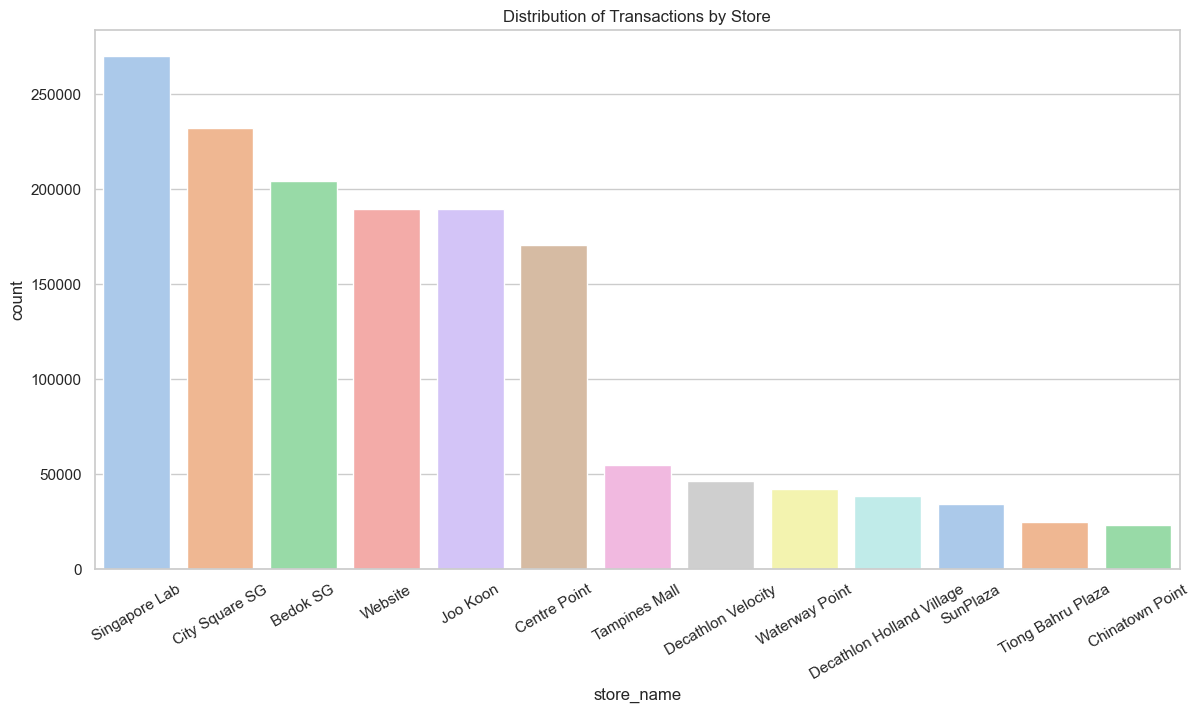

In [15]:
# create a barplot function for reusability
def barplot(data, x, y, hue = None, title= None, ax = None):

    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 7))

    # Create a barplot
    sns.barplot(
        data= data, 
        x= x, 
        y= y, 
        hue= hue, 
        palette= 'pastel',
        ax= ax
    )

    # Rotate x-axis labels by 30 degrees for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    # Set the title and labels for clarity
    ax.set_title(title)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

# Set the aesthetic style of the plots
sns.set(style="whitegrid")
transaction_count = filtered_data['store_name'].value_counts().reset_index()
barplot(transaction_count, x ='store_name', y= 'count',title = 'Distribution of Transactions by Store')
plt.show()

As we can see Singapore Lab holds the greatest number of transactions, followed by City square, Bedok, etc.

Check the basket value of each store to see which store have stronger revenue capacity more directly.

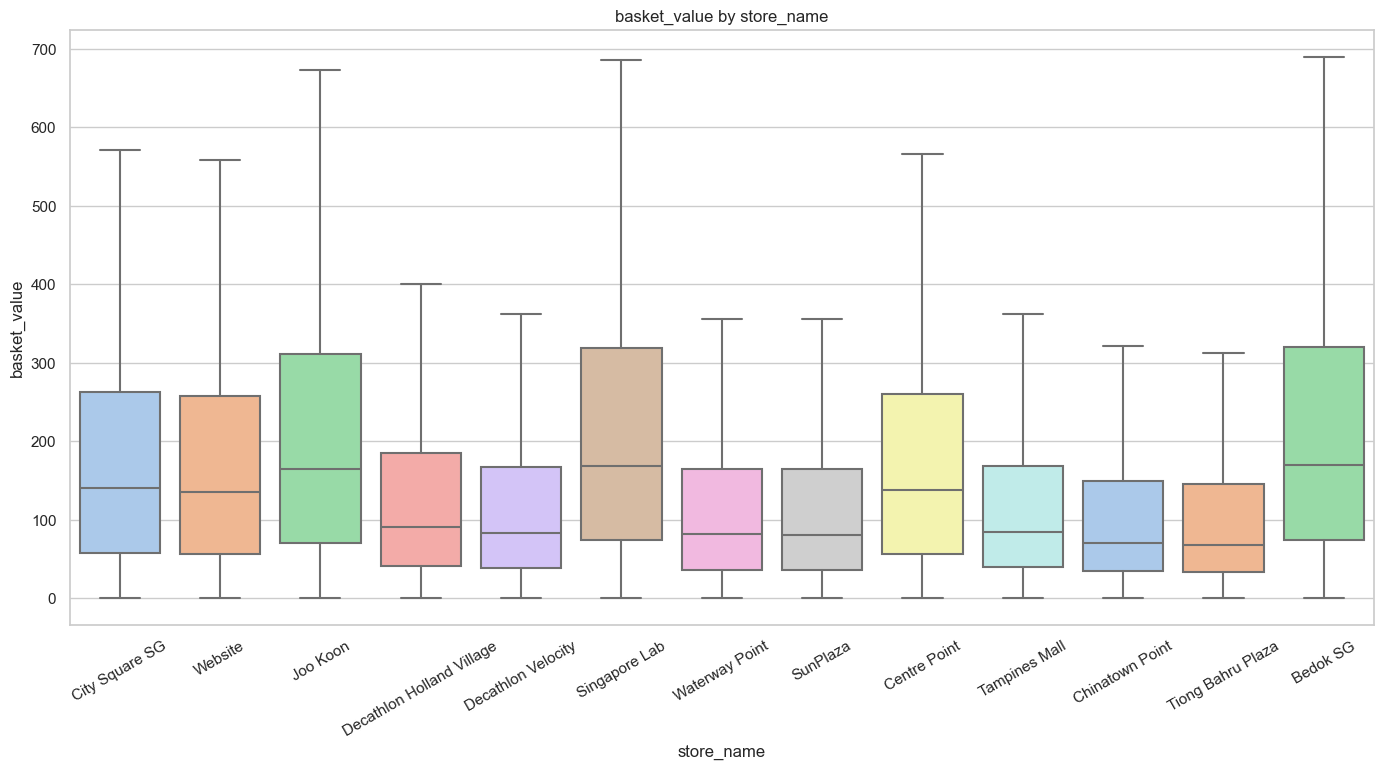

In [16]:
# create a boxplot function for reusability
def boxplot(data, x, y, ax = None):
    if ax is None:
        fig, axes = plt.subplots(figsize=(14, 7))

    # Create a boxplot according to the given x and y
    sns.boxplot(data=data, x=x, y=y, palette='pastel', ax=ax, showfliers=False)

    # Set titles and labels for the subplots
    ax.set_title(f'{y} by {x}')
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    plt.tight_layout() 


fig, ax = plt.subplots(figsize=(14, 7))
boxplot(filtered_data, 'store_name', 'basket_value', ax)
# Rotate x-axis labels by 30 degrees for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
# Show the overall plots
plt.show()

The graph illustrates that Singapore Lab and Bedok SG are leading in terms of basket value, correlating with their high transaction volumes as observed from a prior graph. However, there is an anomaly; City Square SG, despite having the second-highest transaction count, shares a comparable basket value range with Centre Point, which ranks sixth in transaction frequency.

To identify which transaction is belong to members and which is belong to non-members, a new "membership_status" column is added to the dataset.

In [17]:
# if the purchase have no customer id, then it is a non-member
filtered_data.loc[:,'membership_status']= filtered_data['ctm_customer_id'].apply(lambda x: 'Non-member' if x == 'missing' else 'Member')

/var/folders/dc/r_dz_xzd1fsgcdjwcdg7nnk80000gn/T/ipykernel_32221/1138240702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:,'membership_status']= filtered_data['ctm_customer_id'].apply(lambda x: 'Non-member' if x == 'missing' else 'Member')


Check how many percentage of the purchase are from members

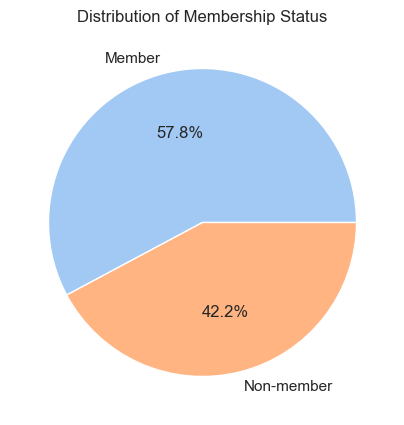

In [18]:
colors = sns.color_palette('pastel')[0:5]

def piechart(data, labels, title=None, colors=None, figsize=(5, 5)):
    # Adjust the figure size
    plt.figure(figsize=figsize)
    
    plt.title(title)
    plt.pie(data, labels=labels, colors=colors, autopct='%.01f%%')
    plt.show()

labels = filtered_data['membership_status'].value_counts().index


piechart(filtered_data['membership_status'].value_counts(), labels,
         title='Distribution of Membership Status', colors=colors)

As we can see the transactions of members constitute the higher majority.

Check how the distribution of basket size and basket value by members and non-mememebers look like

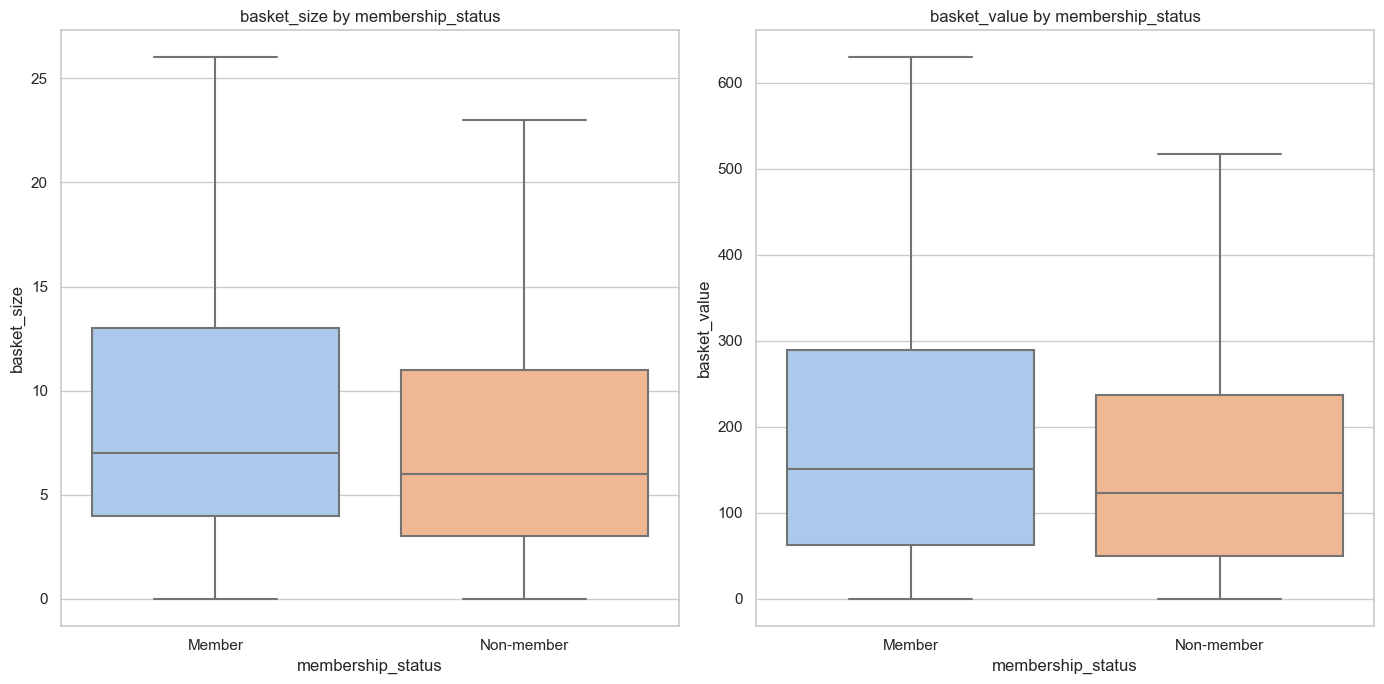

In [19]:
# Create first subplot for basket_size, and second subplot for basket_value
fig, axes = plt.subplots(1, 2, figsize=(14, 7))
boxplot(filtered_data, 'membership_status', 'basket_size', axes[0])
boxplot(filtered_data, 'membership_status', 'basket_value', axes[1])
# Show the overall plots
plt.show()

We can see the members are tend to have larger basket size and higher basket value than the non-members, where the difference in basket value is even larger, which shows the effectiveness of brand loyalty.

## TASK A:  The average basket size and average basket value of members and non-members per store

Creating a summary dataframe so information can be checked directly.

In [20]:
info_per_store = filtered_data.copy()

# Calculate the average basket size and value per store
info_per_store = info_per_store.groupby(['store_name', 'membership_status']).agg(
    average_basket_size=('basket_size', 'mean'),
    average_basket_value=('basket_value', 'mean')
)

info_per_store

average_basket_size  \
store_name                membership_status                        
Bedok SG                  Member                       11.478623   
                          Non-member                    9.875786   
Centre Point              Member                       10.040725   
                          Non-member                    8.488904   
Chinatown Point           Member                        5.721429   
                          Non-member                    4.885814   
City Square SG            Member                       10.057044   
                          Non-member                    8.281199   
Decathlon Holland Village Member                        6.807990   
                          Non-member                    5.927930   
Decathlon Velocity        Member                        6.531718   
                          Non-member                    5.752244   
Joo Koon                  Member                       11.867418   
                          Non-member                    9.559958   
Singapore Lab             Member                       11.464521   
                          Non-member                    9.882106   
SunPlaza                  Member                        6.512890   
                          Non-member                    5.512278   
Tampines Mall             Member                        6.725672   
                          Non-member                    5.862167   
Tiong Bahru Plaza         Member                        5.677299   
                          Non-member                    4.950485   
Waterway Point            Member                        6.124617   
                          Non-member                    5.093647   
Website                   Member                        7.979353   
                          Non-member                    5.505097   

                                             average_basket_value  
store_name                membership_status                        
Bedok SG                  Member                       239.097406  
                          Non-member                   206.060026  
Centre Point              Member                       202.185356  
                          Non-member                   171.371836  
Chinatown Point           Member                       112.304538  
                          Non-member                    99.847821  
City Square SG            Member                       206.871015  
                          Non-member                   173.089006  
Decathlon Holland Village Member                       145.043988  
                          Non-member                   129.668431  
Decathlon Velocity        Member                       131.526764  
                          Non-member                   116.984993  
Joo Koon                  Member                       240.311154  
                          Non-member                   193.356469  
Singapore Lab             Member                       236.796385  
                          Non-member                   205.648686  
SunPlaza                  Member                       133.866889  
                          Non-member                   114.191892  
Tampines Mall             Member                       134.251941  
                          Non-member                   116.364281  
Tiong Bahru Plaza         Member                       109.398918  
                          Non-member                    96.933280  
Waterway Point            Member                       126.396878  
                          Non-member                   109.504147  
Website                   Member                       185.531599  
                          Non-member                   136.782113

Simply look at the dataset above, it shows great difference that members spent much more than non-members with larger basket size.

Next, visualize the average basket size and average basket value of members and non-members per store

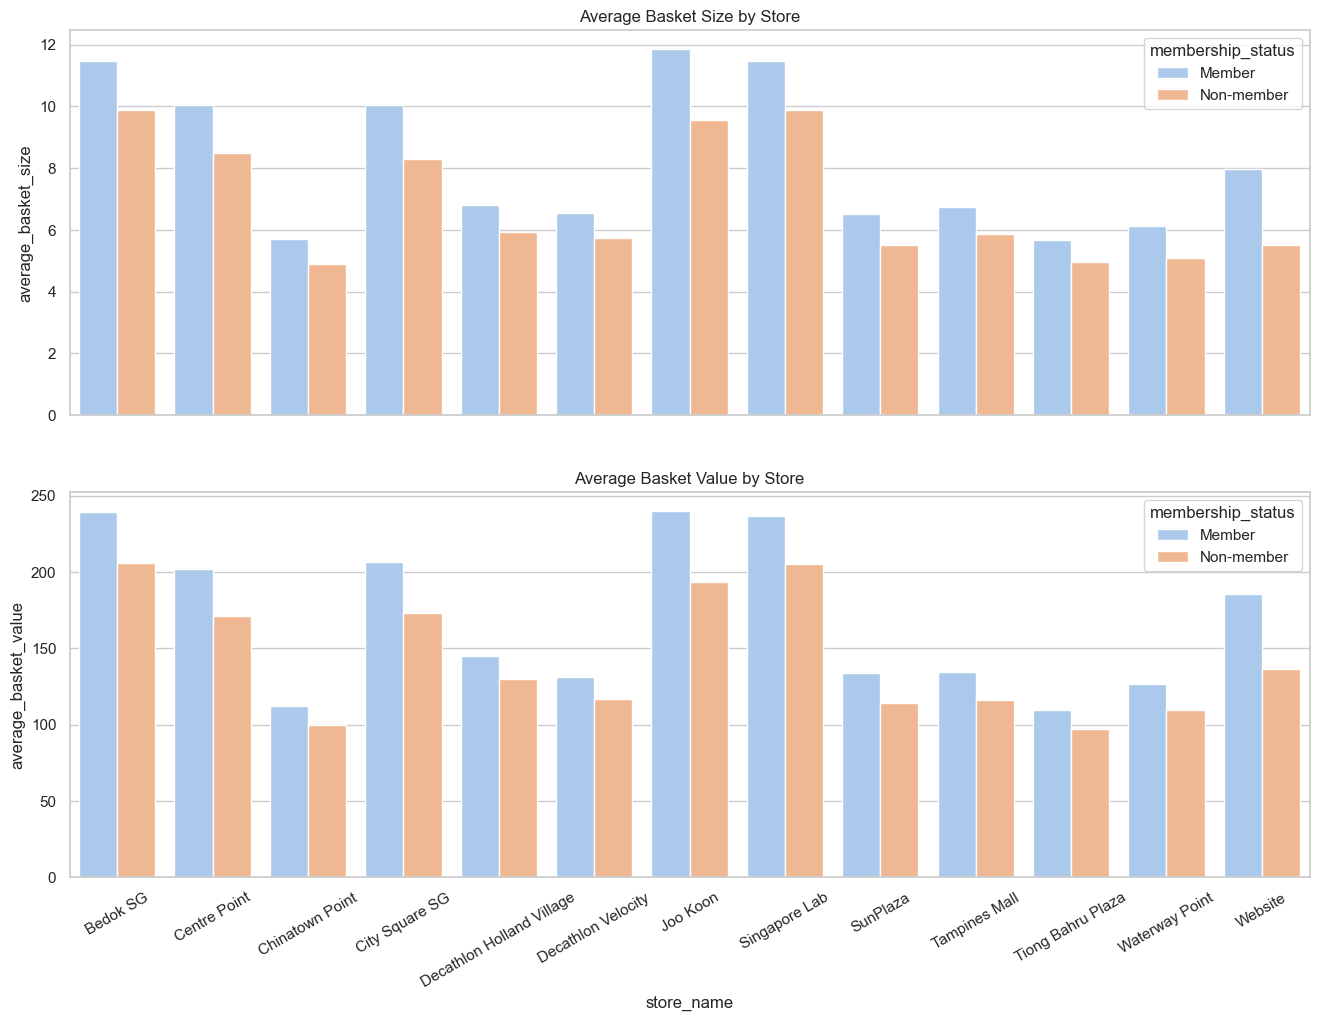

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(16, 11), sharex=True) 

# Plot the average basket size by store on the first subplot
barplot(info_per_store.reset_index(), x='store_name', y='average_basket_size',
         hue='membership_status', title='Average Basket Size by Store', ax=axes[0])

# Plot the average basket value by store on the second subplot
barplot(info_per_store.reset_index(), x='store_name', y='average_basket_value',
         hue='membership_status', title='Average Basket Value by Store', ax=axes[1])

# Remove the x-axis label from the first subplot
axes[0].set_xlabel('') 

# Show the overall plots
plt.show()


The chart clearly illustrates that larger stores, as determined by the greater number of transactions previously observed in the "Distribution of Transactions per Store" bar chart, not only have higher average basket sizes and values but also exhibit a more marked distinction between the purchasing behaviors of members and non-members. 

This observation emphasizes the dual effects of store size and membership status: larger stores amplify the differences in consumer spending habits, while membership status is a significant factor in the increased average size and value of purchases.  

 Additionally, the similar patterns observed in the average basket size and value across each store underscore a strong correlation between the two metrics.  

## Part B: Find the proportion (in %) of members who shopped at each channel

Through search on the official Decathlon Singapore website, the following categories to the stores are made.

* Experience Store: Singapore Lab, Bedok SG, Centre Point, Joo Koon, City Square SG, Chinatown Point
* C&C Store: Decathlon Holland Village, Tampines Mall, Tiong Bahru Plaza, SunPlaza, Waterway, Decathlon Velocity.  
* transactions on the website are classified as Online.

In [22]:
# According to the categorization of the stores, label the store type
experience_stores = ['Singapore Lab', 'Bedok SG', 'Centre Point', 'Joo Koon', 'City Square SG', 'Chinatown Point']
cc_stores = ['Decathlon Holland Village', 'Tampines Mall', 'Tiong Bahru Plaza', 'SunPlaza', 'Waterway', 'Decathlon Velocity']

def label_store(row):
    if row['store_name'] in experience_stores:
        return 'Experience Store'
    elif row['store_name'] in cc_stores:
        return 'C&C Store'
    else:
        return 'Online'

filtered_data.loc[:,'store_type'] = filtered_data.apply(label_store, axis=1)

/var/folders/dc/r_dz_xzd1fsgcdjwcdg7nnk80000gn/T/ipykernel_32221/2814013813.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:,'store_type'] = filtered_data.apply(label_store, axis=1)


In [23]:
customer_data = filtered_data[['ctm_customer_id', 'store_type']]

# filter out the non-members which labeled as "missing" now
customer_data = customer_data[customer_data['ctm_customer_id'] != 'missing']
# aggregate on customer id, and combine the store type they visited
grouped_ctm_data = customer_data.groupby('ctm_customer_id').agg({'store_type': lambda x: ', '.join(set(x))}).reset_index()
# convert the combines of string to list
grouped_ctm_data['store_type'] = grouped_ctm_data['store_type'].str.split(', ')

def label_channel(row):
    
    if len(row) == 1:
        return row[0] + ' exclusively' # Single store type
    elif len(row) > 1 and len(row) < 3:
        return 'Mix of ' + ' and '.join(row)  # Multiple store types
    else:
        return 'Customer of all channels'  # All store types

grouped_ctm_data['channel'] = grouped_ctm_data["store_type"].apply(label_channel)
grouped_ctm_data.drop(columns=["store_type"])

,ctm_customer_id,channel
0,000DFTLRKY,Experience Store exclusively
1,000FX6RHTM,Experience Store exclusively
2,000NZ1KH93,Mix of C&C Store and Experience Store
3,000R842PBV,Online exclusively
4,0014SWGO7X,Experience Store exclusively
...,...,...
377454,ZZZMIYQG58,Experience Store exclusively
377455,ZZZPD2IMD6,Online exclusively
377456,ZZZS1QUNOD,Experience Store exclusively
377457,ZZZUB8CDE9,Customer of all channels


treemap

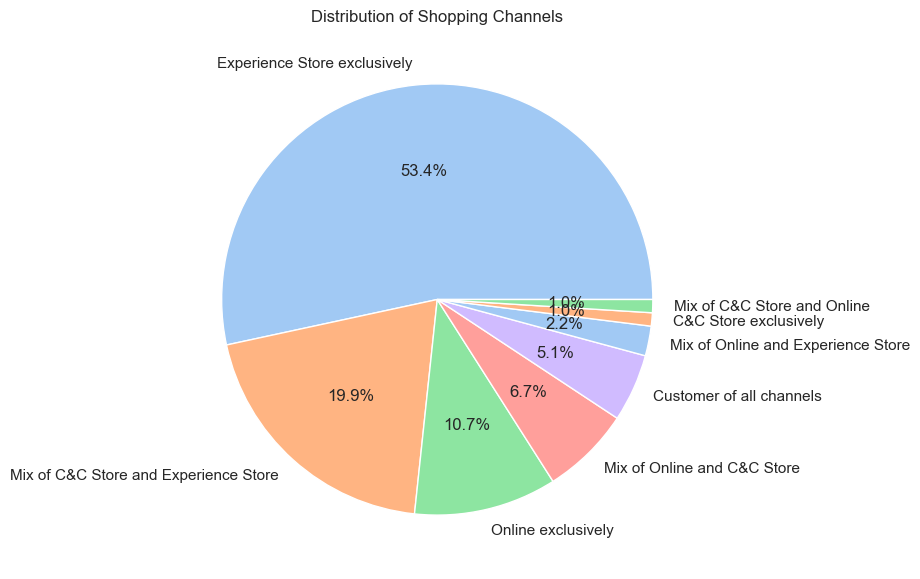

In [24]:
colors = sns.color_palette('pastel')[0:5]
figsize = (7, 7)
# reuse the piechart function to plot the distribution of customer channels
piechart(grouped_ctm_data['channel'].value_counts(), grouped_ctm_data['channel'].unique(),
         title='Distribution of Shopping Channels', colors=colors, figsize=figsize)


The pie chart demonstrates that a significant proportion of customers, 53.4%, favor the Experience Store, showcasing a strong preference for in-store shopping experiences. Additionally, 19.9% of customers engage in shopping through both C&C and Experience Stores. 

On the other hand, only 6.7% of customers are dedicated online shoppers, indicating that while online shopping is significant, it doesn't eclipse the popularity of physical stores in this particular data set. The smallest group of customers, at 2%, shop exclusively at C&C Stores, hinting that these stores might benefit from being paired with other shopping platforms.   

Overall, conventional in-person shopping at Experience Stores remains the most popular shopping method among these customers.

## Part C: Timing of the day analysis

To see the popularity for purchase against the time of the day, we aggregate the date on hours and calculate the total turnover, then plot the line chart for their relationship

Plot the linechart for number of transactions by hour for both store types

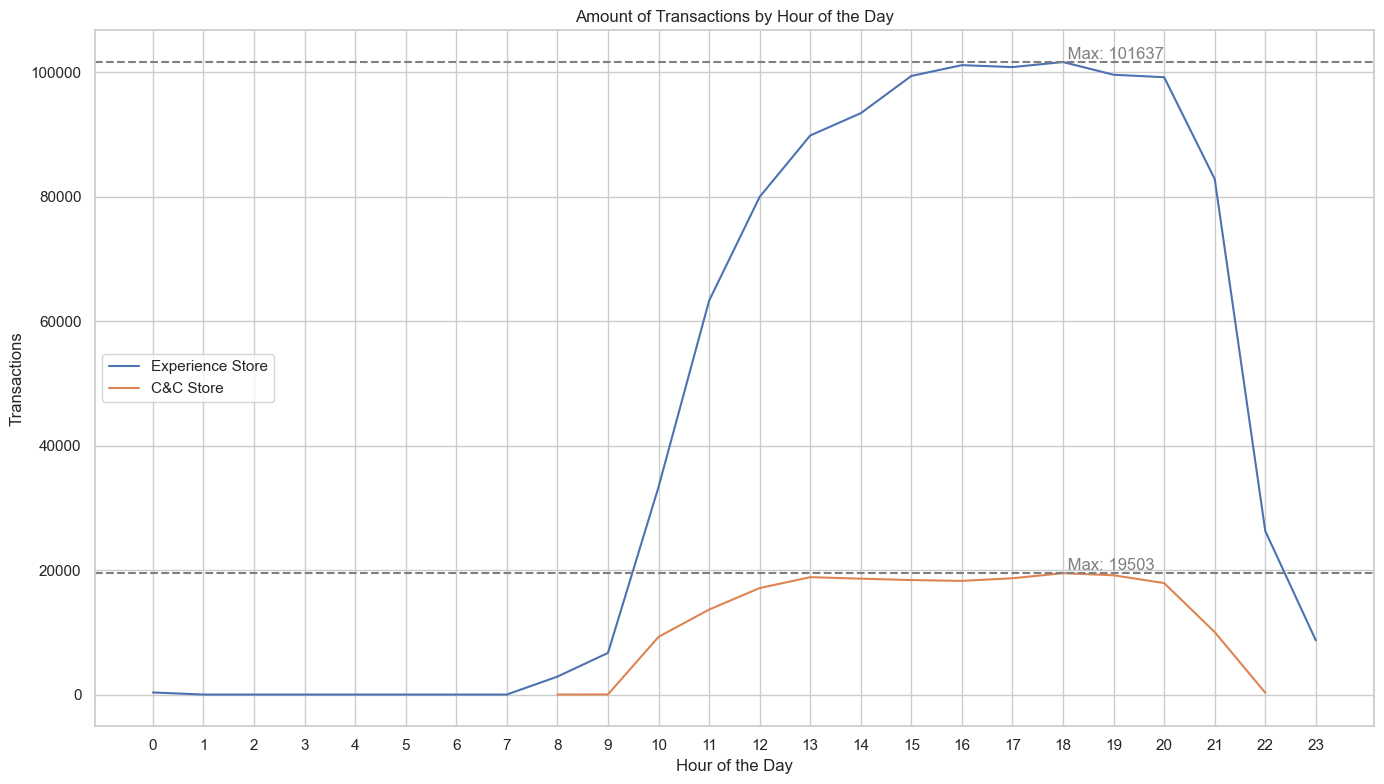

In [25]:
# define a lineplot function for reusability
def lineplot(data, x, y, label, ax=None, range= None, show_max=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 7))
    
    ax.plot(data.index, data, label=label)
    
    if range:
        ax.set_xticks(range) 

    ax.set_title(f'Amount of {y} by {x}')
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    if show_max:
        max_value = data.max()
        ax.axhline(max_value, color='grey', ls='--')
        ax.text(data.idxmax(), max_value, f' Max: {max_value}', color='grey', va='bottom')
    
    ax.legend()

# Filter the data for Experience Stores and C&C Stores
experience_store_data = filtered_data[filtered_data['store_type'] == 'Experience Store']
cc_store_data = filtered_data[filtered_data['store_type'] == 'C&C Store']

# Group the data by hour and count the number of transactions
experience_store_hourly_transactions = experience_store_data.groupby(experience_store_data['the_date_transaction'].dt.hour).size()
cc_store_hourly_transactions = cc_store_data.groupby(cc_store_data['the_date_transaction'].dt.hour).size()

fig, ax = plt.subplots(figsize=(14, 8))

timestamps = range(0, 24)
# Plot the number of transactions by hour for both store types
lineplot(experience_store_hourly_transactions, 'Hour of the Day', 'Transactions', 'Experience Store', ax, range=timestamps, show_max=True)
lineplot(cc_store_hourly_transactions, 'Hour of the Day', 'Transactions', 'C&C Store', ax, range=timestamps, show_max=True)

# Show the overall plot
plt.tight_layout() 
plt.show()

Plot the amount of turnover by hour of the day for each store types

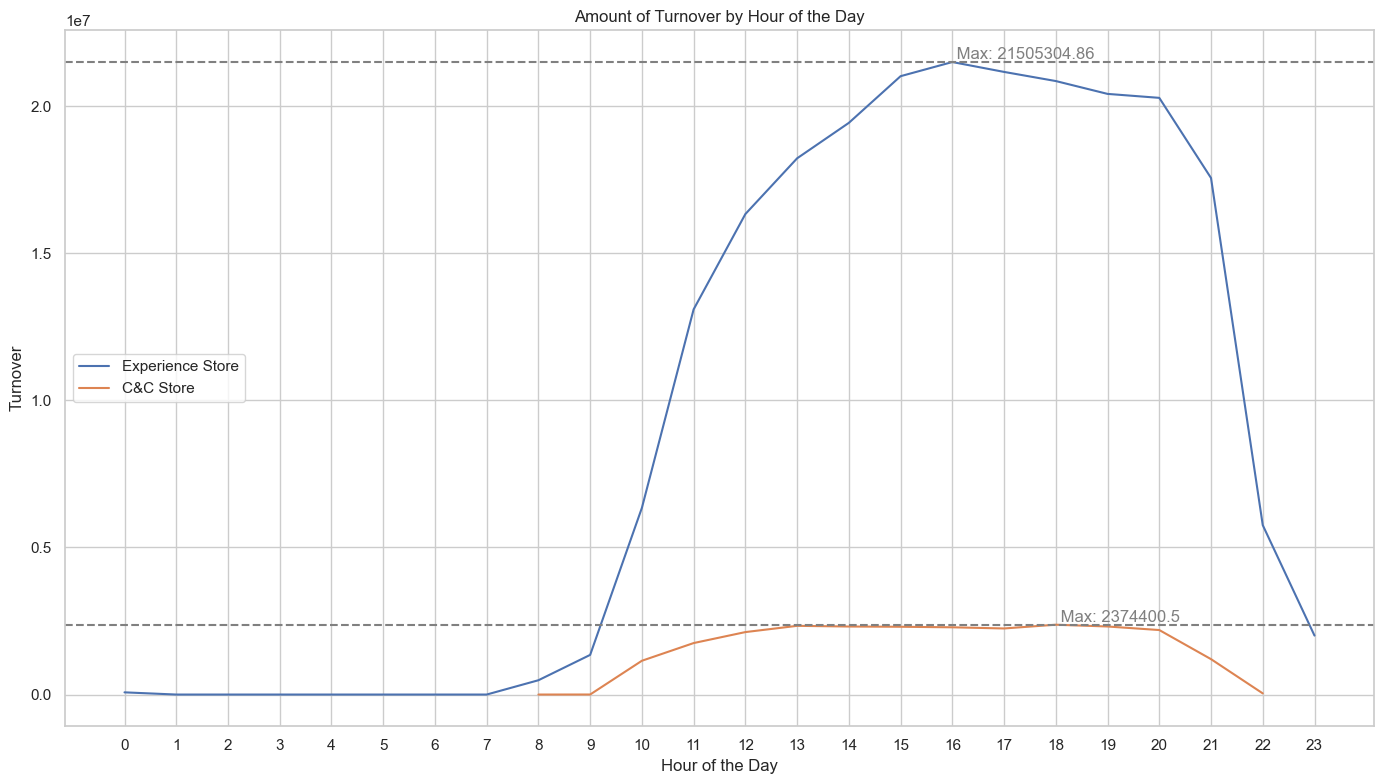

In [26]:
experience_store_hourly_Turnover = experience_store_data.groupby(experience_store_data['the_date_transaction'].dt.hour).agg({'basket_value': 'sum'}).round(2).squeeze()
cc_store_hourly_Turnover = cc_store_data.groupby(cc_store_data['the_date_transaction'].dt.hour).agg({'basket_value': 'sum'}).round(2).squeeze()

fig, ax = plt.subplots(figsize=(14, 8))

# Plot the number of transactions by hour for both store types
lineplot(experience_store_hourly_Turnover, 'Hour of the Day', 'Turnover', 'Experience Store', ax, range=timestamps, show_max=True)
lineplot(cc_store_hourly_Turnover, 'Hour of the Day', 'Turnover', 'C&C Store', ax, range=timestamps, show_max=True)

# Show the overall plot
plt.tight_layout() 
plt.show()

Observing from the two graphs, for experience stores, we can see the highest transaction number happened at 16pm to 18pm, while 15pm distinctively have the highest turnover amount. The statistic for C&C store would be much more stable throughout the day, from 13pm to 19pm, the number of transaction and amount of turnover are held almost in a constant level.

# Part 2 Data Science for sales data forecasting

For Data Science part, the preprocessed dataset would be leveraged again that generated previously

In [27]:
filtered_data

,the_transaction_id,the_date_transaction,store_name,ctm_customer_id,the_to_type,basket_size,basket_value,membership_status,store_type
0,7-1034-1034-20200701100516-207-8331,2020-07-01 10:05:16,City Square SG,MTAJOFUFWV,offline,2,80.0,Member,Experience Store
1,7-1034-1034-20200701102229-206-657,2020-07-01 10:22:29,City Square SG,missing,offline,11,204.5,Non-member,Experience Store
2,7-1034-1034-20200701102316-215-8331,2020-07-01 10:23:16,City Square SG,missing,offline,12,135.5,Non-member,Experience Store
3,7-1034-1034-20200701102336-213-877,2020-07-01 10:23:36,City Square SG,XBXET6KMLI,offline,14,382.0,Member,Experience Store
4,7-1034-1034-20200701102419-209-1071,2020-07-01 10:24:19,City Square SG,missing,offline,9,25.0,Non-member,Experience Store
...,...,...,...,...,...,...,...,...,...
1567326,7-969-969-20201231215824-210-564,2020-12-31 21:58:24,Bedok SG,HCGYMJSFNL,offline,25,676.0,Member,Experience Store
1567327,7-969-969-20201231220032-209-5435,2020-12-31 22:00:32,Bedok SG,29QPFMO88Z,offline,4,198.5,Member,Experience Store
1567330,7-969-969-20201231220439-101-3609,2020-12-31 22:04:39,Bedok SG,missing,offline,5,0.0,Non-member,Experience Store
1567331,7-969-969-20201231220505-208-5286,2020-12-31 22:05:05,Bedok SG,UL2RB0165O,offline,1,96.5,Member,Experience Store


First, we focus on the offline part of the data, aggregate it to 1 hour. and before designing the model, preprocess is needed again which is to standardize the data. The machine learning models typically perform better when the input data is standardized because this helps the optimization algorithm converge more quickly.

In [28]:
# Filter the data for offline transactions
offline_data = filtered_data[filtered_data['the_to_type'] == 'offline']
# Group the data by hour and sum the basket value
# aggregate the data by one hour so keep as more training data as possible
offline_turnover = offline_data.groupby([pd.Grouper(key='the_date_transaction', freq='H')]).agg({'basket_value': 'sum'})
# standardize the data for the model that will be used
scaler = StandardScaler()
index = offline_turnover.index
columns = offline_turnover.columns
offline_turnover = scaler.fit_transform(offline_turnover)
# convert the standardized data back to dataframe
offline_turnover = pd.DataFrame(offline_turnover, index=index, columns=columns)


We can now the total basket_value(day turn over) has been already standardized, which would have mean of 0 and standard deviation of 1

In [29]:
offline_turnover

,basket_value
the_date_transaction,
2020-07-01 08:00:00,-0.862764
2020-07-01 09:00:00,-0.764812
2020-07-01 10:00:00,-0.269472
2020-07-01 11:00:00,0.243768
2020-07-01 12:00:00,0.514317
...,...
2020-12-31 19:00:00,1.305427
2020-12-31 20:00:00,1.220931
2020-12-31 21:00:00,1.183878


plot the offline turnover by date to see the trend first

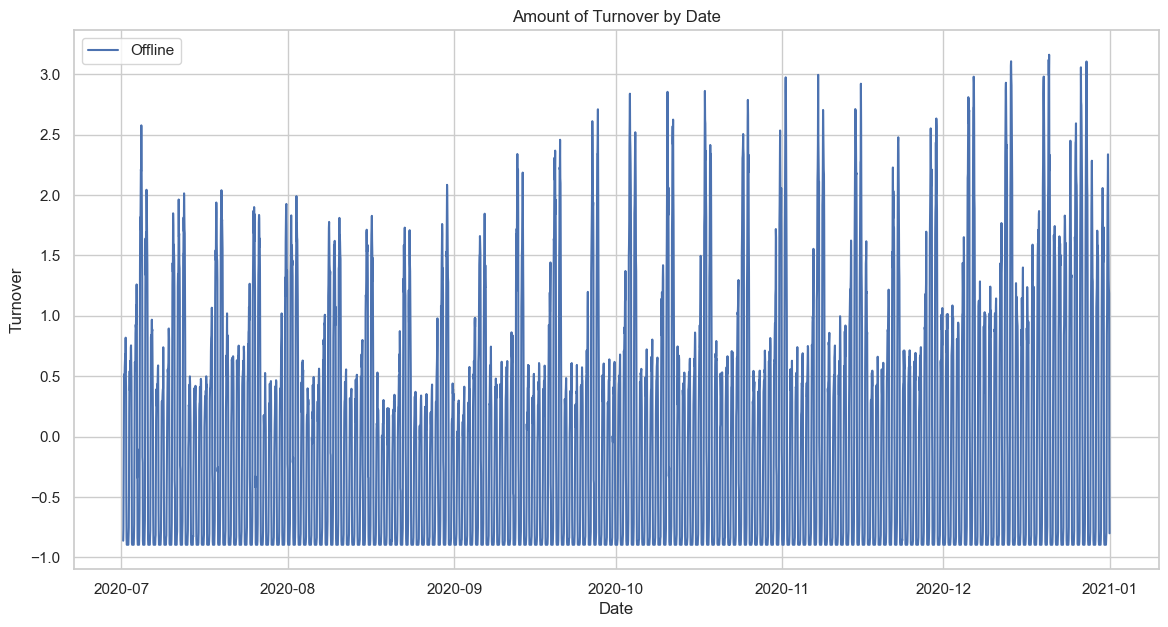

In [30]:
lineplot(offline_turnover['basket_value'], 'Date', 'Turnover', 'Offline', ax=None)

Then here we gain the feature and label form the time series data, where the a window slice is used to predict the next value, so we split the data into the window and next value for the prediction, which the window would be treated as features, and the next value of the window would be treated as label. 168 hours are set for the window size here, as it's covers a whole week and so may help to capture all paterns in the week

Basically the features used is just the time series data that segmented to slices, and next value of the window is used as label. Although adding other features like the day of the week, is holiday or not, etc. is considered, but the result is not satisfied. Moreover, some important features like the turnover value of the exact day last year cannot be generated, as the whole dataset only have the period of 6 months.

In [31]:
def windowed_dataset(df, window_size):
    df_np = df.to_numpy()
    X = []
    y = []
    # iterate through the dataset and create the windowed dataset
    for i in range(len(df_np) - window_size):
        # data across the window size is the feature
        feature = [[a] for a in df_np[i :i+window_size]]
        X.append(feature)
        # next value after the window size is the label
        label = df_np[i+window_size]
        y.append(label)
    return np.array(X), np.array(y)

# set window size to 168 hours, which covers a whole week
window_size = 168
X, y = windowed_dataset(offline_turnover, window_size)
X.shape, y.shape

((4240, 168, 1, 1), (4240, 1))

In [32]:
# split the dataset into training, validation, and test sets
def train_val_test_split(X, y, train_size, val_size):
    X_train, y_train = X[:train_size], y[:train_size]
    X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
    X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]
    return X_train, y_train, X_val, y_val, X_test, y_test
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X, y, 1800, 200)

Create the deep learning model, where LSTM would be the one of the current state of art method for predicting the time-series data

In [33]:
def create_model():
    model = tf.keras.models.Sequential([
    # add convolutional layer to capture the temporal patterns
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
    strides=1,
    activation="ReLU",
    padding='causal', input_shape=[window_size, 1]), 
    tf.keras.layers.LSTM(64, return_sequences=True),
    # add dropout layer to potentially prevent overfitting
    tf.keras.layers.Dropout(0.2),
    # utlize LSTM layer to capture the long-term dependencies
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    # add dense layers to make the final prediction
    tf.keras.layers.Dense(30, activation="ReLU"),
    tf.keras.layers.Dense(10, activation="ReLU"),
    tf.keras.layers.Dense(1, activation ='linear') ])
    model.summary()
    return model

model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 168, 64)           256       
                                                                 
 lstm (LSTM)                 (None, 168, 64)           33024     
                                                                 
 dropout (Dropout)           (None, 168, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 168, 64)           33024     
                                                                 
 dropout_1 (Dropout)         (None, 168, 64)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 30)                1

Next, train the model and using X_train and y_train data that separated before, and use X_val and y_val for validation test.

In [34]:
def training(model, X_train, y_train, X_val, y_val):
    # Save the model weight for the best performance
    callback = tf.keras.callbacks.ModelCheckpoint('model', save_best_only=True)
    
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 0.001)
    # compile the model with mean squared error as loss function, and evaluate the model with mean absolute error
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=optimizer, metrics=["mae"])
    history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),callbacks= [callback])
    # return the trained model
    return history

history = training(model, X_train, y_train, X_val, y_val)

Epoch 1/100
57/57 [==============================] - ETA: 0s - loss: 0.4874 - mae: 0.4846INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 11s 162ms/step - loss: 0.4874 - mae: 0.4846 - val_loss: 0.4275 - val_mae: 0.3471
Epoch 2/100
57/57 [==============================] - ETA: 0s - loss: 0.2475 - mae: 0.3328INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 9s 151ms/step - loss: 0.2475 - mae: 0.3328 - val_loss: 0.2404 - val_mae: 0.3408
Epoch 3/100
57/57 [==============================] - ETA: 0s - loss: 0.1135 - mae: 0.2282INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 8s 148ms/step - loss: 0.1135 - mae: 0.2282 - val_loss: 0.1207 - val_mae: 0.2191
Epoch 4/100
57/57 [==============================] - ETA: 0s - loss: 0.1002 - mae: 0.2066INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 8s 146ms/step - loss: 0.1002 - mae: 0.2066 - val_loss: 0.1061 - val_mae: 0.2440
Epoch 5/100
57/57 [==============================] - ETA: 0s - loss: 0.0578 - mae: 0.1610INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 9s 151ms/step - loss: 0.0578 - mae: 0.1610 - val_loss: 0.0574 - val_mae: 0.1594
Epoch 6/100
57/57 [==============================] - ETA: 0s - loss: 0.0508 - mae: 0.1431INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 8s 145ms/step - loss: 0.0508 - mae: 0.1431 - val_loss: 0.0574 - val_mae: 0.1457
Epoch 7/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0432 - mae: 0.1313 - val_loss: 0.0688 - val_mae: 0.1622
Epoch 8/100
57/57 [==============================] - ETA: 0s - loss: 0.0464 - mae: 0.1401INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 9s 152ms/step - loss: 0.0464 - mae: 0.1401 - val_loss: 0.0420 - val_mae: 0.1422
Epoch 9/100
57/57 [==============================] - 6s 100ms/step - loss: 0.0403 - mae: 0.1258 - val_loss: 0.0522 - val_mae: 0.1436
Epoch 10/100
57/57 [==============================] - ETA: 0s - loss: 0.0341 - mae: 0.1168INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 8s 148ms/step - loss: 0.0341 - mae: 0.1168 - val_loss: 0.0346 - val_mae: 0.1223
Epoch 11/100
57/57 [==============================] - 6s 101ms/step - loss: 0.0366 - mae: 0.1227 - val_loss: 0.0347 - val_mae: 0.1283
Epoch 12/100
57/57 [==============================] - ETA: 0s - loss: 0.0351 - mae: 0.1214INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 9s 151ms/step - loss: 0.0351 - mae: 0.1214 - val_loss: 0.0308 - val_mae: 0.1123
Epoch 13/100
57/57 [==============================] - 6s 99ms/step - loss: 0.0469 - mae: 0.1332 - val_loss: 0.0546 - val_mae: 0.1333
Epoch 14/100
57/57 [==============================] - 6s 98ms/step - loss: 0.0349 - mae: 0.1218 - val_loss: 0.0372 - val_mae: 0.1172
Epoch 15/100
57/57 [==============================] - 6s 98ms/step - loss: 0.0454 - mae: 0.1331 - val_loss: 0.0374 - val_mae: 0.1255
Epoch 16/100
57/57 [==============================] - 6s 101ms/step - loss: 0.0359 - mae: 0.1219 - val_loss: 0.0573 - val_mae: 0.1551
Epoch 17/100
57/57 [==============================] - 6s 99ms/step - loss: 0.0447 - mae: 0.1347 - val_loss: 0.0395 - val_mae: 0.1335
Epoch 18/100
57/57 [==============================] - 6s 99ms/step - loss: 0.0269 - mae: 0.1078 - val_loss: 0.0391 - val_mae: 0.1249
Epoch 19/100
57/57 [==============================] - 6s 99ms/step - loss: 0.025

INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 8s 149ms/step - loss: 0.0314 - mae: 0.1138 - val_loss: 0.0289 - val_mae: 0.1010
Epoch 21/100
57/57 [==============================] - ETA: 0s - loss: 0.0233 - mae: 0.0977INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 8s 150ms/step - loss: 0.0233 - mae: 0.0977 - val_loss: 0.0242 - val_mae: 0.1001
Epoch 22/100
57/57 [==============================] - 6s 107ms/step - loss: 0.0234 - mae: 0.0999 - val_loss: 0.0363 - val_mae: 0.1139
Epoch 23/100
57/57 [==============================] - 6s 103ms/step - loss: 0.0319 - mae: 0.1180 - val_loss: 0.0308 - val_mae: 0.1141
Epoch 24/100
57/57 [==============================] - 6s 112ms/step - loss: 0.0361 - mae: 0.1240 - val_loss: 0.0365 - val_mae: 0.1216
Epoch 25/100
57/57 [==============================] - 6s 105ms/step - loss: 0.0250 - mae: 0.1011 - val_loss: 0.0490 - val_mae: 0.1244
Epoch 26/100
57/57 [==============================] - 6s 104ms/step - loss: 0.0363 - mae: 0.1258 - val_loss: 0.0308 - val_mae: 0.1099
Epoch 27/100
57/57 [==============================] - 6s 106ms/step - loss: 0.0219 - mae: 0.0982 - val_loss: 0.0337 - val_mae: 0.1043
Epoch 28/100
57/57 [==============================] - 6s 105ms/step - loss:

INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 10s 170ms/step - loss: 0.0235 - mae: 0.0964 - val_loss: 0.0210 - val_mae: 0.0901
Epoch 31/100
57/57 [==============================] - 6s 104ms/step - loss: 0.0239 - mae: 0.0981 - val_loss: 0.0252 - val_mae: 0.0999
Epoch 32/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0278 - mae: 0.1029 - val_loss: 0.0306 - val_mae: 0.1046
Epoch 33/100
57/57 [==============================] - 6s 100ms/step - loss: 0.0328 - mae: 0.1095 - val_loss: 0.0305 - val_mae: 0.1012
Epoch 34/100
57/57 [==============================] - 6s 106ms/step - loss: 0.0252 - mae: 0.1016 - val_loss: 0.0275 - val_mae: 0.0995
Epoch 35/100
57/57 [==============================] - 6s 107ms/step - loss: 0.0284 - mae: 0.1065 - val_loss: 0.0319 - val_mae: 0.1279
Epoch 36/100
57/57 [==============================] - ETA: 0s - loss: 0.0184 - mae: 0.0891INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 8s 149ms/step - loss: 0.0184 - mae: 0.0891 - val_loss: 0.0174 - val_mae: 0.0811
Epoch 37/100
57/57 [==============================] - 6s 105ms/step - loss: 0.0159 - mae: 0.0825 - val_loss: 0.0200 - val_mae: 0.0808
Epoch 38/100
57/57 [==============================] - 6s 103ms/step - loss: 0.0168 - mae: 0.0824 - val_loss: 0.0251 - val_mae: 0.0934
Epoch 39/100
57/57 [==============================] - 6s 106ms/step - loss: 0.0193 - mae: 0.0926 - val_loss: 0.0237 - val_mae: 0.0989
Epoch 40/100
57/57 [==============================] - 6s 111ms/step - loss: 0.0252 - mae: 0.1022 - val_loss: 0.0199 - val_mae: 0.0958
Epoch 41/100
57/57 [==============================] - 6s 105ms/step - loss: 0.0185 - mae: 0.0883 - val_loss: 0.0220 - val_mae: 0.0938
Epoch 42/100
57/57 [==============================] - 6s 108ms/step - loss: 0.0171 - mae: 0.0836 - val_loss: 0.0311 - val_mae: 0.1038
Epoch 43/100
57/57 [==============================] - 6s 105ms/step - loss:

INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 9s 153ms/step - loss: 0.0170 - mae: 0.0808 - val_loss: 0.0173 - val_mae: 0.0801
Epoch 54/100
57/57 [==============================] - 6s 104ms/step - loss: 0.0155 - mae: 0.0796 - val_loss: 0.0222 - val_mae: 0.1026
Epoch 55/100
57/57 [==============================] - 6s 106ms/step - loss: 0.0184 - mae: 0.0905 - val_loss: 0.0208 - val_mae: 0.0856
Epoch 56/100
57/57 [==============================] - 6s 104ms/step - loss: 0.0164 - mae: 0.0824 - val_loss: 0.0205 - val_mae: 0.0806
Epoch 57/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0219 - mae: 0.0936 - val_loss: 0.0299 - val_mae: 0.0999
Epoch 58/100
57/57 [==============================] - 6s 107ms/step - loss: 0.0253 - mae: 0.0953 - val_loss: 0.0475 - val_mae: 0.1343
Epoch 59/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0226 - mae: 0.0968 - val_loss: 0.0214 - val_mae: 0.0918
Epoch 60/100
57/57 [==============================] - 6s 103ms/step - loss:

INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 8s 148ms/step - loss: 0.0146 - mae: 0.0786 - val_loss: 0.0161 - val_mae: 0.0770
Epoch 65/100
57/57 [==============================] - 6s 104ms/step - loss: 0.0135 - mae: 0.0738 - val_loss: 0.0227 - val_mae: 0.0906
Epoch 66/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0144 - mae: 0.0788 - val_loss: 0.0313 - val_mae: 0.0945
Epoch 67/100
57/57 [==============================] - 6s 105ms/step - loss: 0.0189 - mae: 0.0811 - val_loss: 0.0374 - val_mae: 0.1083
Epoch 68/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0331 - mae: 0.1148 - val_loss: 0.0428 - val_mae: 0.1263
Epoch 69/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0195 - mae: 0.0883 - val_loss: 0.0194 - val_mae: 0.0799
Epoch 70/100
57/57 [==============================] - 6s 103ms/step - loss: 0.0130 - mae: 0.0731 - val_loss: 0.0179 - val_mae: 0.0781
Epoch 71/100
57/57 [==============================] - 6s 102ms/step - loss:

INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 9s 159ms/step - loss: 0.0146 - mae: 0.0777 - val_loss: 0.0137 - val_mae: 0.0774
Epoch 83/100
57/57 [==============================] - 6s 104ms/step - loss: 0.0126 - mae: 0.0738 - val_loss: 0.0221 - val_mae: 0.0910
Epoch 84/100
57/57 [==============================] - 6s 105ms/step - loss: 0.0135 - mae: 0.0759 - val_loss: 0.0182 - val_mae: 0.0910
Epoch 85/100
57/57 [==============================] - ETA: 0s - loss: 0.0168 - mae: 0.0827INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


57/57 [==============================] - 8s 147ms/step - loss: 0.0168 - mae: 0.0827 - val_loss: 0.0118 - val_mae: 0.0680
Epoch 86/100
57/57 [==============================] - 6s 106ms/step - loss: 0.0139 - mae: 0.0753 - val_loss: 0.0291 - val_mae: 0.1015
Epoch 87/100
57/57 [==============================] - 6s 109ms/step - loss: 0.0148 - mae: 0.0786 - val_loss: 0.0187 - val_mae: 0.0850
Epoch 88/100
57/57 [==============================] - 6s 105ms/step - loss: 0.0134 - mae: 0.0744 - val_loss: 0.0289 - val_mae: 0.1076
Epoch 89/100
57/57 [==============================] - 6s 111ms/step - loss: 0.0147 - mae: 0.0795 - val_loss: 0.0193 - val_mae: 0.0783
Epoch 90/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0267 - mae: 0.0977 - val_loss: 0.0239 - val_mae: 0.1167
Epoch 91/100
57/57 [==============================] - 6s 102ms/step - loss: 0.0154 - mae: 0.0836 - val_loss: 0.0217 - val_mae: 0.0877
Epoch 92/100
57/57 [==============================] - 6s 102ms/step - loss:

57/57 [==============================] - 2s 25ms/step


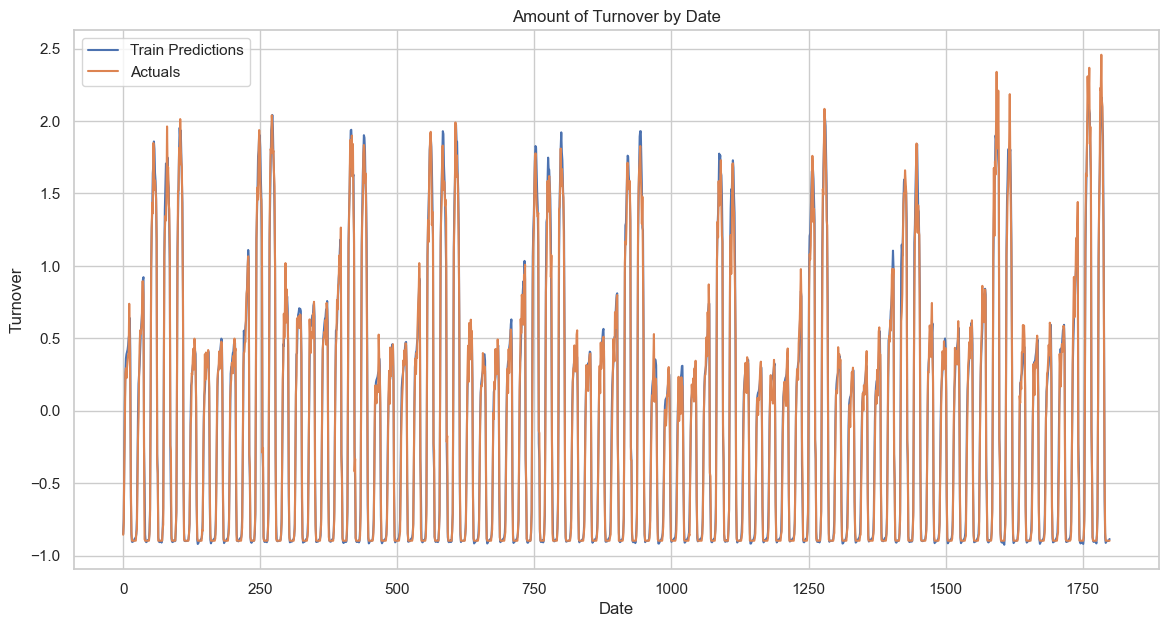

In [35]:
# see the train data prediction result, showing on lineplot
def train_result(X_train, y_train, model,ax):
    train_predictions = model.predict(X_train).flatten()
    train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actuals': y_train.flatten()})
    # reusing the lineplot function defined before
    lineplot(train_results['Train Predictions'], 'Date', 'Turnover', 'Train Predictions', ax=ax)
    lineplot(train_results['Actuals'], 'Date', 'Turnover', 'Actuals', ax=ax)

fig, ax = plt.subplots(figsize=(14, 7))
train_result(X_train, y_train, model,ax)
plt.show()

7/7 [==============================] - 0s 24ms/step


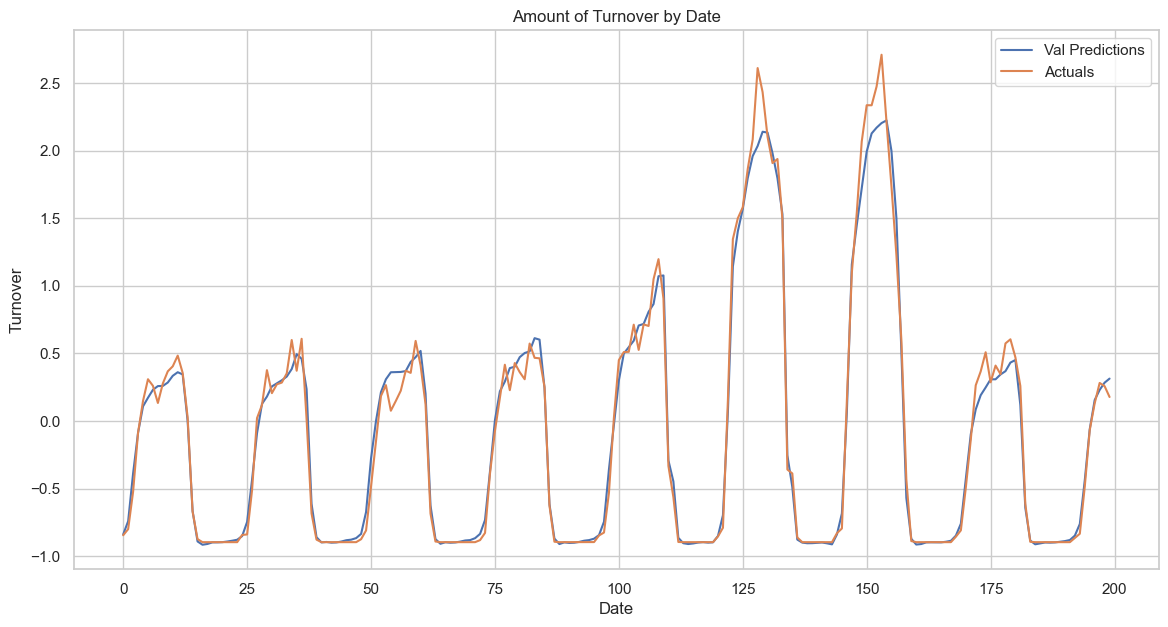

In [36]:
# see the validation data prediction result, showing on lineplot
def val_result(X_val, y_val, model,ax):
    val_predictions = model.predict(X_val). flatten()
    val_results = pd. DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val.flatten()})
    lineplot(val_results['Val Predictions'], 'Date', 'Turnover', 'Val Predictions', ax=ax)
    lineplot(val_results['Actuals'], 'Date', 'Turnover', 'Actuals', ax=ax)
fig, ax = plt.subplots(figsize=(14, 7))
val_result(X_val, y_val, model,ax)
plt.show()

70/70 [==============================] - 2s 27ms/step


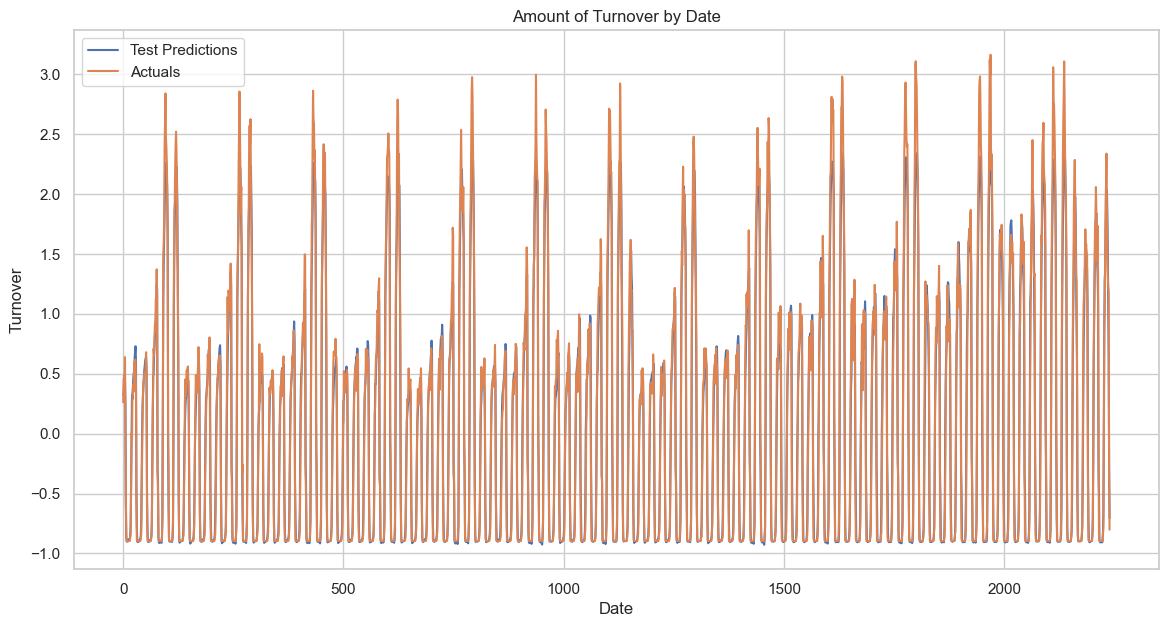

In [37]:
# see the test data prediction result, showing on lineplot
def test_result(X_test, y_test, model,ax):
    test_predictions = model.predict(X_test).flatten()
    test_results = pd. DataFrame(data={'Test Predictions': test_predictions, 'Actuals' :y_test.flatten()})
    lineplot(test_results['Test Predictions'], 'Date', 'Turnover', 'Test Predictions', ax=ax)
    lineplot(test_results['Actuals'], 'Date', 'Turnover', 'Actuals', ax=ax)
fig, ax = plt.subplots(figsize=(14, 7))
test_result(X_test, y_test, model,ax)
plt.show()

We can see from the grpah, the predicting lineplot is very close to the actual turnover plot, even for the testing data, showing the effectiveness and accuracy of the model in predicting the turnover value.

Now the final task is use the existing data to forecast for the future value, to do this, the final window slice of the original dataset is feeded to the trained model, then a single forecast value of the next hour would be generated, add this forecasted data to the original dataset, then continuous repeating these work until the targeted future 3 months data are all generated.

1/1 [==============================] - 0s 17ms/step


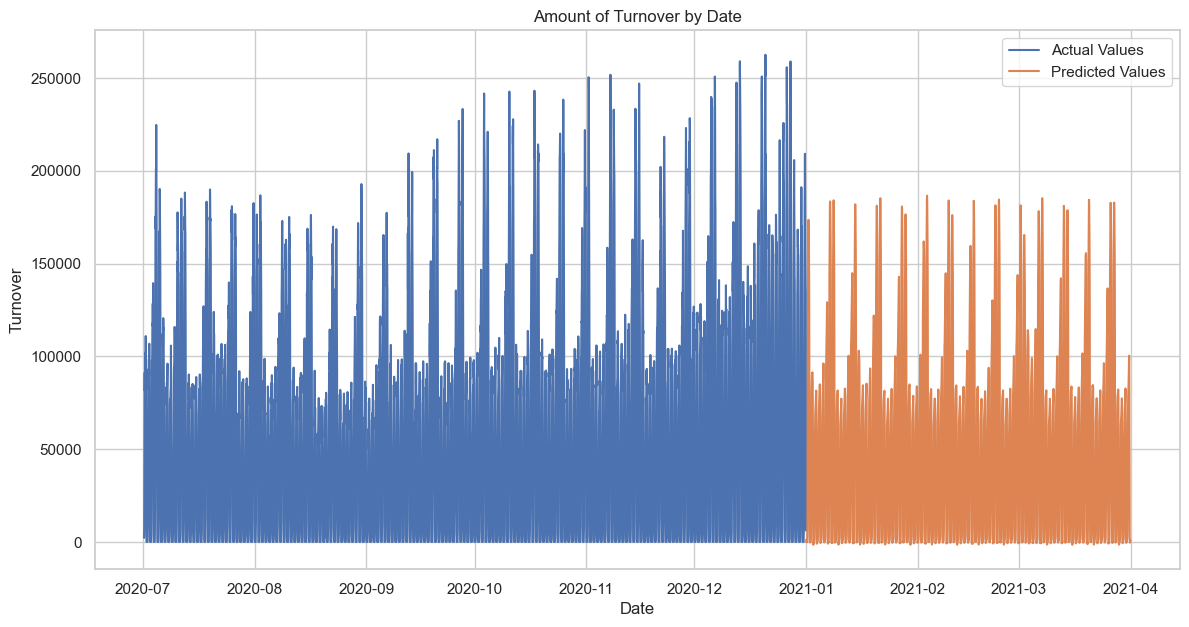

In [38]:
def predict_future(data, model, scaler, ax, window_size):
    # Define the number of future time steps to predict (3 months)
    # 3 months = 3*30*24 hours, one step represents one hour
    future_steps = 3*30*24

    # take the last window_size data as input
    true_data = data.copy()
    input = true_data[-window_size:].values.reshape(1, window_size, 1, 1)

    # Predict future values using the trained model
    predicted_values = []
    for _ in range(future_steps):
        # predict the next value
        prediction = model.predict(input)[0][0]
        predicted_values.append(prediction)
        # update the input for the next prediction
        true_data.loc[true_data.index[-1] + pd.DateOffset(hours=1)] = prediction
        input = true_data[-window_size:].values.reshape(1, window_size, 1, 1)
    
    # store the true index and columns for reversing the standardization to the original scale
    true_index = data.index
    true_columns = data.columns
    # Create timestamp index for the predicted values
    index = pd.date_range(start=data.index[-1] + pd.Timedelta(hours=1),
                        periods=future_steps, freq='H')

    predicted_values = scaler.inverse_transform(np.array(predicted_values).reshape(-1, 1))

    # Create a dataframe for the predicted values
    predicted_values = predicted_values.ravel()
    predicted_results = pd.DataFrame(data={'Predicted Values': predicted_values}, index=index)
    # Inverse transform the offline_turnover data
    data = scaler.inverse_transform(data)
    data = pd.DataFrame(data, index=true_index, columns=true_columns)

    # Plot the predicted values along with the actual values in the same plot
    lineplot(data['basket_value'], 'Date', 'Turnover', 'Actual Values',ax=ax)
    lineplot(predicted_results['Predicted Values'], 'Date', 'Turnover', 'Predicted Values',ax=ax)
    return predicted_results

fig, ax = plt.subplots(figsize=(14, 7))
offline_futurre = predict_future(offline_turnover, model, scaler, ax, window_size)
plt.show()

Observing from the graph with forecasting values, though the future values are forecasted successfully, but with less seasonal variation compared to the actual data. This may cause of the limit availability of the original dataset's length. Since now the model is trained only with the window size of 1 week, it may not study the variation out of this period, as we can see the seasional period occuring roughly evey 3 months. Whereas, this window size is not supported because of the data limitation. so overall turnover value would likely to be much less than the actual situation.

Finally, to also forecast the future value of the online data, we can leverage all the related functions defined before, and directly applied to the case of online data.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 168, 64)           256       
                                                                 
 lstm_6 (LSTM)               (None, 168, 64)           33024     
                                                                 
 dropout_4 (Dropout)         (None, 168, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 168, 64)           33024     
                                                                 
 dropout_5 (Dropout)         (None, 168, 64)           0         
                                                                 
 lstm_8 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 30)               

INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 16s 128ms/step - loss: 0.4754 - mae: 0.4444 - val_loss: 0.3863 - val_mae: 0.3940
Epoch 2/100
110/110 [==============================] - ETA: 0s - loss: 0.2726 - mae: 0.3093INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 14s 129ms/step - loss: 0.2726 - mae: 0.3093 - val_loss: 0.3599 - val_mae: 0.3775
Epoch 3/100
110/110 [==============================] - 11s 102ms/step - loss: 0.2255 - mae: 0.2778 - val_loss: 0.3652 - val_mae: 0.3799
Epoch 4/100
110/110 [==============================] - ETA: 0s - loss: 0.2368 - mae: 0.2918INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 16s 141ms/step - loss: 0.2368 - mae: 0.2918 - val_loss: 0.3455 - val_mae: 0.3769
Epoch 5/100
110/110 [==============================] - ETA: 0s - loss: 0.2051 - mae: 0.2566INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 17s 154ms/step - loss: 0.2051 - mae: 0.2566 - val_loss: 0.3247 - val_mae: 0.3399
Epoch 6/100
110/110 [==============================] - ETA: 0s - loss: 0.2124 - mae: 0.2624INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 15s 135ms/step - loss: 0.2124 - mae: 0.2624 - val_loss: 0.3133 - val_mae: 0.3390
Epoch 7/100
110/110 [==============================] - ETA: 0s - loss: 0.2044 - mae: 0.2574INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 15s 137ms/step - loss: 0.2044 - mae: 0.2574 - val_loss: 0.2933 - val_mae: 0.3238
Epoch 8/100
110/110 [==============================] - 11s 104ms/step - loss: 0.2021 - mae: 0.2542 - val_loss: 0.3310 - val_mae: 0.3363
Epoch 9/100
110/110 [==============================] - 11s 102ms/step - loss: 0.2026 - mae: 0.2529 - val_loss: 0.3317 - val_mae: 0.3531
Epoch 10/100
110/110 [==============================] - 11s 102ms/step - loss: 0.1919 - mae: 0.2457 - val_loss: 0.4176 - val_mae: 0.4245
Epoch 11/100
110/110 [==============================] - 11s 101ms/step - loss: 0.2055 - mae: 0.2606 - val_loss: 0.3006 - val_mae: 0.3499
Epoch 12/100
110/110 [==============================] - 11s 99ms/step - loss: 0.2026 - mae: 0.2555 - val_loss: 0.2980 - val_mae: 0.3286
Epoch 13/100
110/110 [==============================] - 11s 99ms/step - loss: 0.2012 - mae: 0.2517 - val_loss: 0.3169 - val_mae: 0.3406
Epoch 14/100
110/110 [==============================] - ET

INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 14s 128ms/step - loss: 0.1894 - mae: 0.2487 - val_loss: 0.2849 - val_mae: 0.3184
Epoch 15/100
110/110 [==============================] - 11s 104ms/step - loss: 0.1864 - mae: 0.2425 - val_loss: 0.2855 - val_mae: 0.3263
Epoch 16/100
110/110 [==============================] - 11s 103ms/step - loss: 0.1867 - mae: 0.2411 - val_loss: 0.3245 - val_mae: 0.3360
Epoch 17/100
110/110 [==============================] - ETA: 0s - loss: 0.1851 - mae: 0.2386INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 14s 128ms/step - loss: 0.1851 - mae: 0.2386 - val_loss: 0.2746 - val_mae: 0.3157
Epoch 18/100
110/110 [==============================] - 11s 100ms/step - loss: 0.1823 - mae: 0.2368 - val_loss: 0.2855 - val_mae: 0.3228
Epoch 19/100
110/110 [==============================] - 12s 105ms/step - loss: 0.1813 - mae: 0.2353 - val_loss: 0.3053 - val_mae: 0.3467
Epoch 20/100
110/110 [==============================] - ETA: 0s - loss: 0.1901 - mae: 0.2484INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 14s 123ms/step - loss: 0.1901 - mae: 0.2484 - val_loss: 0.2730 - val_mae: 0.3294
Epoch 21/100
110/110 [==============================] - ETA: 0s - loss: 0.1816 - mae: 0.2378INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 14s 128ms/step - loss: 0.1816 - mae: 0.2378 - val_loss: 0.2721 - val_mae: 0.3160
Epoch 22/100
110/110 [==============================] - ETA: 0s - loss: 0.1902 - mae: 0.2390INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 15s 133ms/step - loss: 0.1902 - mae: 0.2390 - val_loss: 0.2687 - val_mae: 0.3363
Epoch 23/100
110/110 [==============================] - 11s 100ms/step - loss: 0.1895 - mae: 0.2481 - val_loss: 0.2925 - val_mae: 0.3258
Epoch 24/100
110/110 [==============================] - 11s 100ms/step - loss: 0.1768 - mae: 0.2331 - val_loss: 0.4028 - val_mae: 0.4122
Epoch 25/100
110/110 [==============================] - 11s 102ms/step - loss: 0.1840 - mae: 0.2411 - val_loss: 0.2710 - val_mae: 0.3067
Epoch 26/100
110/110 [==============================] - 11s 100ms/step - loss: 0.1834 - mae: 0.2342 - val_loss: 0.2781 - val_mae: 0.3213
Epoch 27/100
110/110 [==============================] - ETA: 0s - loss: 0.1784 - mae: 0.2358INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 14s 127ms/step - loss: 0.1784 - mae: 0.2358 - val_loss: 0.2651 - val_mae: 0.3049
Epoch 28/100
110/110 [==============================] - 11s 102ms/step - loss: 0.1739 - mae: 0.2290 - val_loss: 0.2722 - val_mae: 0.3058
Epoch 29/100
110/110 [==============================] - 11s 99ms/step - loss: 0.1748 - mae: 0.2301 - val_loss: 0.2695 - val_mae: 0.3033
Epoch 30/100
110/110 [==============================] - ETA: 0s - loss: 0.1745 - mae: 0.2271INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 14s 130ms/step - loss: 0.1745 - mae: 0.2271 - val_loss: 0.2582 - val_mae: 0.2979
Epoch 31/100
110/110 [==============================] - 11s 100ms/step - loss: 0.1709 - mae: 0.2305 - val_loss: 0.2631 - val_mae: 0.3038
Epoch 32/100
110/110 [==============================] - 11s 99ms/step - loss: 0.1792 - mae: 0.2357 - val_loss: 0.2609 - val_mae: 0.3084
Epoch 33/100
110/110 [==============================] - 11s 100ms/step - loss: 0.1716 - mae: 0.2316 - val_loss: 0.2667 - val_mae: 0.3014
Epoch 34/100
110/110 [==============================] - 11s 102ms/step - loss: 0.1773 - mae: 0.2308 - val_loss: 0.2670 - val_mae: 0.3065
Epoch 35/100
110/110 [==============================] - 11s 100ms/step - loss: 0.1735 - mae: 0.2326 - val_loss: 0.2946 - val_mae: 0.3351
Epoch 36/100
110/110 [==============================] - 11s 100ms/step - loss: 0.1753 - mae: 0.2314 - val_loss: 0.2686 - val_mae: 0.3133
Epoch 37/100
110/110 [==============================] -

INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 14s 124ms/step - loss: 0.1710 - mae: 0.2288 - val_loss: 0.2570 - val_mae: 0.2945
Epoch 41/100
110/110 [==============================] - 11s 101ms/step - loss: 0.1760 - mae: 0.2304 - val_loss: 0.2692 - val_mae: 0.3116
Epoch 42/100
110/110 [==============================] - 11s 101ms/step - loss: 0.1744 - mae: 0.2321 - val_loss: 0.2637 - val_mae: 0.2974
Epoch 43/100
110/110 [==============================] - 11s 101ms/step - loss: 0.1723 - mae: 0.2290 - val_loss: 0.2588 - val_mae: 0.3051
Epoch 44/100
110/110 [==============================] - 11s 101ms/step - loss: 0.1751 - mae: 0.2346 - val_loss: 0.2709 - val_mae: 0.3057
Epoch 45/100
110/110 [==============================] - 11s 100ms/step - loss: 0.1672 - mae: 0.2274 - val_loss: 0.2745 - val_mae: 0.3162
Epoch 46/100
110/110 [==============================] - 11s 101ms/step - loss: 0.1632 - mae: 0.2241 - val_loss: 0.2878 - val_mae: 0.3144
Epoch 47/100
110/110 [==============================] 

INFO:tensorflow:Assets written to: model/assets


110/110 [==============================] - 15s 135ms/step - loss: 0.1659 - mae: 0.2281 - val_loss: 0.2490 - val_mae: 0.2953
Epoch 49/100
110/110 [==============================] - 12s 108ms/step - loss: 0.1595 - mae: 0.2235 - val_loss: 0.2656 - val_mae: 0.3025
Epoch 50/100
110/110 [==============================] - 13s 118ms/step - loss: 0.1789 - mae: 0.2350 - val_loss: 0.2696 - val_mae: 0.3161
Epoch 51/100
110/110 [==============================] - 12s 106ms/step - loss: 0.1658 - mae: 0.2240 - val_loss: 0.2532 - val_mae: 0.2951
Epoch 52/100
110/110 [==============================] - 12s 105ms/step - loss: 0.1651 - mae: 0.2261 - val_loss: 0.2632 - val_mae: 0.3168
Epoch 53/100
110/110 [==============================] - 12s 108ms/step - loss: 0.1616 - mae: 0.2256 - val_loss: 0.2627 - val_mae: 0.3050
Epoch 54/100
110/110 [==============================] - 11s 104ms/step - loss: 0.1592 - mae: 0.2210 - val_loss: 0.2806 - val_mae: 0.3102
Epoch 55/100
110/110 [==============================] 

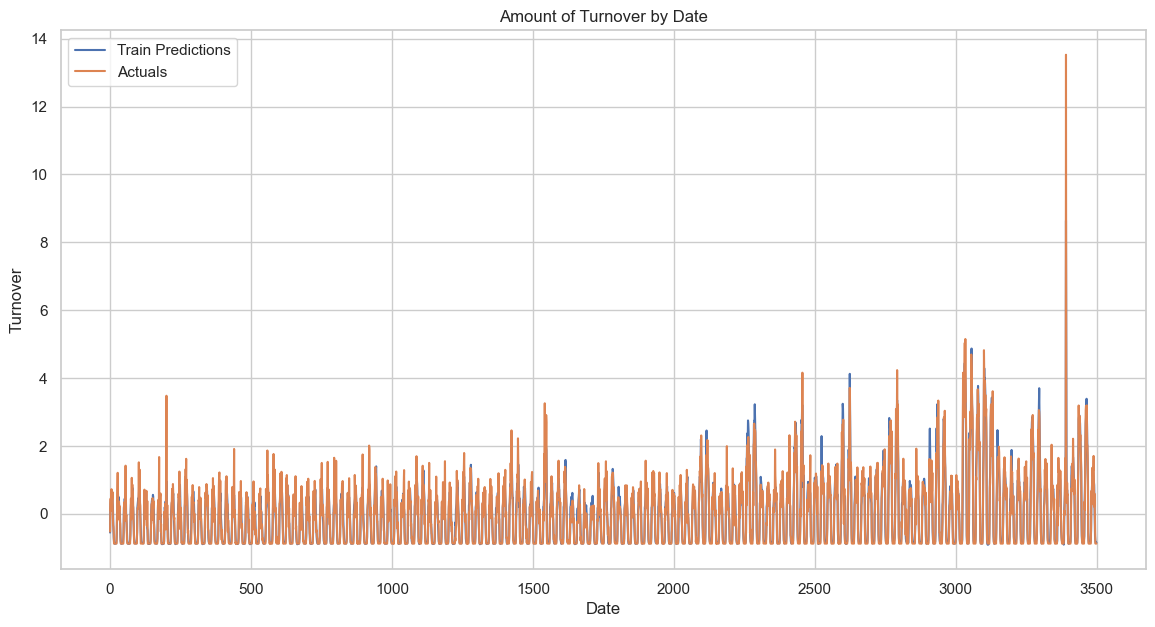

16/16 [==============================] - 0s 27ms/step


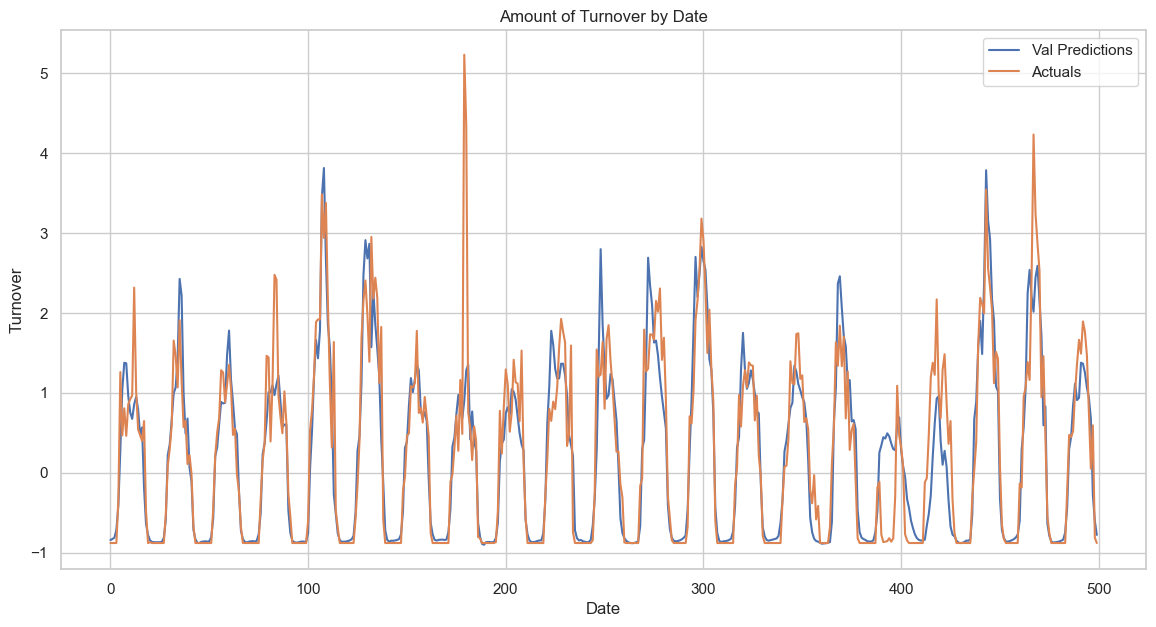

8/8 [==============================] - 0s 26ms/step


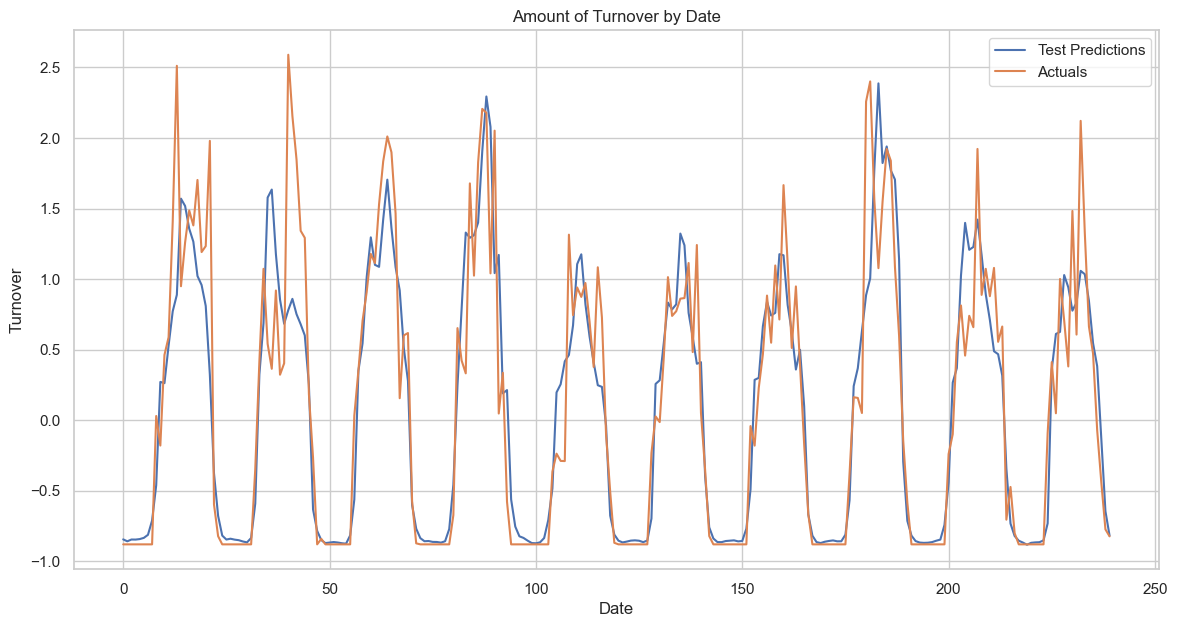

1/1 [==============================] - 0s 16ms/step


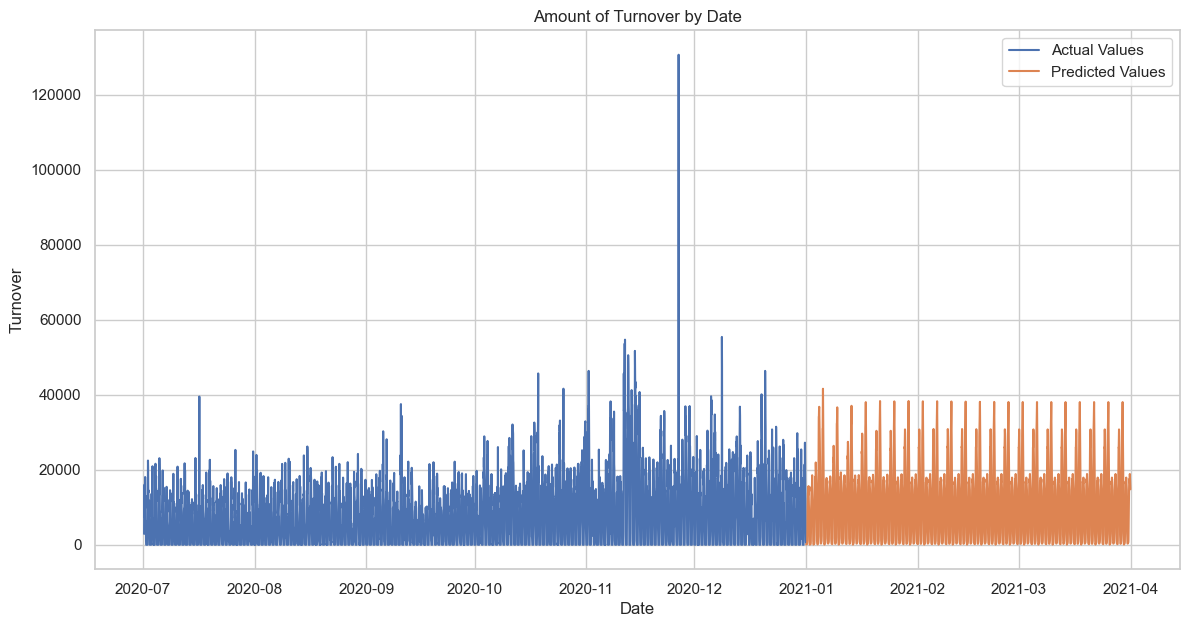

In [40]:
# From the overall preprocessed dataset, extract the the online turn over data
online_data = filtered_data[filtered_data['the_to_type'] == 'online']
# aggregate the data by one hour so keep as more training data as possible
online_turnover = online_data.groupby([pd.Grouper(key='the_date_transaction', freq='H')]).agg({'basket_value': 'sum'})
# standardize the data for the model
scaler = StandardScaler()
index = online_turnover.index
columns = online_turnover.columns
online_turnover = scaler.fit_transform(online_turnover)
online_turnover = pd.DataFrame(online_turnover, index=index, columns=columns)
# create the windowed dataset for the online turnover
windowed_dataset(online_turnover, window_size)
OX, Oy = windowed_dataset(online_turnover, window_size)
# split the dataset into training, validation, and test sets
OX_train, Oy_train, OX_val, Oy_val, OX_test, Oy_test = train_val_test_split(OX, Oy, 3500, 500)
# create the model 
Omodel = create_model()
# generating for a trained model
Ohistory = training(Omodel, OX_train, Oy_train, OX_val, Oy_val)
# see the train data prediction result, showing on lineplot
fig, ax = plt.subplots(figsize=(14, 7))
train_result(OX_train, Oy_train, Omodel,ax)
plt.show()
# see the validation data prediction result, showing on lineplot
fig, ax = plt.subplots(figsize=(14, 7))
val_result(OX_val, Oy_val, Omodel,ax)
plt.show()
# see the test data prediction result, showing on lineplot
fig, ax = plt.subplots(figsize=(14, 7))
test_result(OX_test, Oy_test, Omodel,ax)
plt.show()
# predict the future values for the online turnover
fig, ax = plt.subplots(figsize=(14, 7))
online_futurre = predict_future(online_turnover, Omodel, scaler, ax, window_size)
plt.show()

Similarly, for the online data, the forcasted values also not showing the seasonal variation

In [41]:
offline_sum = offline_futurre['Predicted Values'].sum()
online_sum = online_futurre['Predicted Values'].sum()

print("Sum of turnover for offline data forcasting:", offline_sum)
print("Sum of turnover for online data forcasting:", online_sum)

Sum of turnover for offline prediction: 109646420.0
Sum of turnover for online prediction: 23983830.0


Finally, the sum of the online turnover and offline turnover could be calculated, but as illustrated before, the forecasting would be less than the true situation as the full pattern are not studied for the model.